## Python Web Crawler

In [1]:
from html.parser import HTMLParser  
from urllib.request import urlopen  
from urllib import parse

# Download dir from FTP

Simply Use:
> wget --mirror --continue --no-host-directories --user=username --password=password ftp://hostname/source/path/

# Download Text

http://www.netinstructions.com/how-to-make-a-web-crawler-in-under-50-lines-of-python-code/

In [2]:
# We are going to create a class called LinkParser that inherits some
# methods from HTMLParser which is why it is passed into the definition
class LinkParser(HTMLParser):

    # This is a function that HTMLParser normally has
    # but we are adding some functionality to it
    def handle_starttag(self, tag, attrs):
        # We are looking for the begining of a link. Links normally look
        # like <a href="www.someurl.com"></a>
        if tag == 'a':
            for (key, value) in attrs:
                if key == 'href':
                    # We are grabbing the new URL. We are also adding the
                    # base URL to it. For example:
                    # www.netinstructions.com is the base and
                    # somepage.html is the new URL (a relative URL)
                    #
                    # We combine a relative URL with the base URL to create
                    # an absolute URL like:
                    # www.netinstructions.com/somepage.html
                    newUrl = parse.urljoin(self.baseUrl, value)
                    # And add it to our colection of links:
                    self.links = self.links + [newUrl]

    # This is a new function that we are creating to get links
    # that our spider() function will call
    def getLinks(self, url):
        self.links = []
        # Remember the base URL which will be important when creating
        # absolute URLs
        self.baseUrl = url
        # Use the urlopen function from the standard Python 3 library
        response = urlopen(url)
        # Make sure that we are looking at HTML and not other things that
        # are floating around on the internet (such as
        # JavaScript files, CSS, or .PDFs for example)
        
        # print(response.getheader('Content-Type'))
        
        if response.getheader('Content-Type').startswith('text/html'):
            htmlBytes = response.read()
            # Note that feed() handles Strings well, but not bytes
            # (A change from Python 2.x to Python 3.x)
            htmlString = htmlBytes.decode("utf-8")
            self.feed(htmlString)
            return htmlString, self.links
        else:
            return "",[]

In [3]:
from bs4 import BeautifulSoup

def parseHtml_cnfoodsafety(htmlstring):
    soup = BeautifulSoup(htmlstring, "lxml")    
    title = soup.find_all("h1", class_="artical")
    if title == []:
        title = ''
    else:
        title = title[0].get_text()
        
    content = soup.find_all("div", id="artContent")
    if content == []:
        content = ''
    else:
        content = content[0].get_text()
        
    return title, content

In [4]:
from bs4 import BeautifulSoup

def parseHtml_cfsn(htmlstring):
    
    soup = BeautifulSoup(htmlstring, "html.parser")    
    title = soup.find_all("h1")
    if title == []:
        title = ''
    else:
        title = title[0].get_text()
        
    content = soup.find_all("div", class_="content")
    if content == []:
        content = ''
    else:
        content = content[0].get_text()
    
    # print(title, content)
    
    return title, content

def parseHtml_cfsn_old(htmlstring):
    soup = BeautifulSoup(htmlstring, "lxml")    
    title = soup.find_all("h1")
    if title == []:
        title = ''
    else:
        title = title[0].get_text()
        
    content = soup.find_all("div", id="cont1")
    if content == []:
        content = ''
    else:
        content = content[0].get_text()
        
    return title, content

In [5]:
import pandas as pd

# And finally here is our spider. It takes in an URL, a word to find,
# and the number of pages to search through before giving up
def spider(url, maxPages, pattern):  
    
    pagesToVisit = [url]
    numberVisited = 0
    pagesVisited = []
    df = pd.DataFrame(columns = ['url', 'date', 'title', 'content'])
    # The main loop. Create a LinkParser and get all the links on the page.
    # Also search the page for the word or string
    # In our getLinks function we return the web page
    # (this is useful for searching for the word)
    # and we return a set of links from that web page
    # (this is useful for where to go next)
    while numberVisited < maxPages and pagesToVisit != []:
        numberVisited = numberVisited +1
        # Start from the beginning of our collection of pages to visit:
        url = pagesToVisit[0]
        pagesToVisit = pagesToVisit[1:]
        #print(pagesToVisit)
        try:
            print(numberVisited, "Visiting:", url)
            parser = LinkParser()
            data, links = parser.getLinks(url)
            
            if(url.startswith(pattern)):
                date = url[len(pattern) - 2: len(pattern) - 2 + 9 + 1]
                title = ''
                content = ''
                if 'cnfoodsafety' in url:
                    title, content = parseHtml_cnfoodsafety(data)
                elif 'cfsn' in url:
                    title, content = parseHtml_cfsn(data)
                if content != '':
                    df.loc[-1] = [url, date, title, content] # add a row
                    df.index = df.index + 1
            #print(title, content)
                      
            # Add the pages that we visited to the end of our collection of pages to visit:
            # pagesToVisit = pagesToVisit + links   
            for link in links:
                link = link.replace('#SOHUCS','').replace('#comment','')
                if(link.startswith(pattern) and link not in pagesVisited):
                    # pagesToVisit.extend(links)
                    pagesVisited.append(link)
                    pagesToVisit.append(link)
            print(" **Success!**")
        except:
            print(" **Failed!**")
        
    return df

In [6]:
from datetime import datetime
fname = datetime.now().strftime('%Y%m%d%H%M%S')

def spider_multipage(url, pattern, title, pages, links = 1000):
    '''
    Parameters
    ----------
    url - e.g., https://www.cfsn.cn/front/web/site.bwnews?bwid=1&bwtypeid=0&page=
    pattern - 链接模板，URL前面的主体部分，e.g., https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=
    pages - 共多少页, int or list
    links - 每页最多提取多少链接
    '''

    df = pd.DataFrame(columns = ['url', 'date', 'title', 'content'])
    
    pageurls = []    
    if isinstance(pages, list):
        for p in pages:
            pageurls.append(url + str(p))
    elif isinstance(pages, int):
        for idx in range(1, pages+1):
            pageurls.append(url + str(idx))
    
    for pageurl in pageurls:
        df_tmp = spider(pageurl, links, pattern)
        df = pd.concat([df, df_tmp], ignore_index=True)
        
    df.drop_duplicates(inplace=True) 
    df.insert(0, 'src', title)
    df.insert(0, 'label', '食品安全')
        
    with pd.HDFStore(fname + '.h5',  mode='w') as store:
        store.append('df', df, data_columns= df.columns, format='table')
    print('saved to ', fname)
    
    return df

## 中国食品安全网 - 抽检通告

国家市场监督管理总局发布

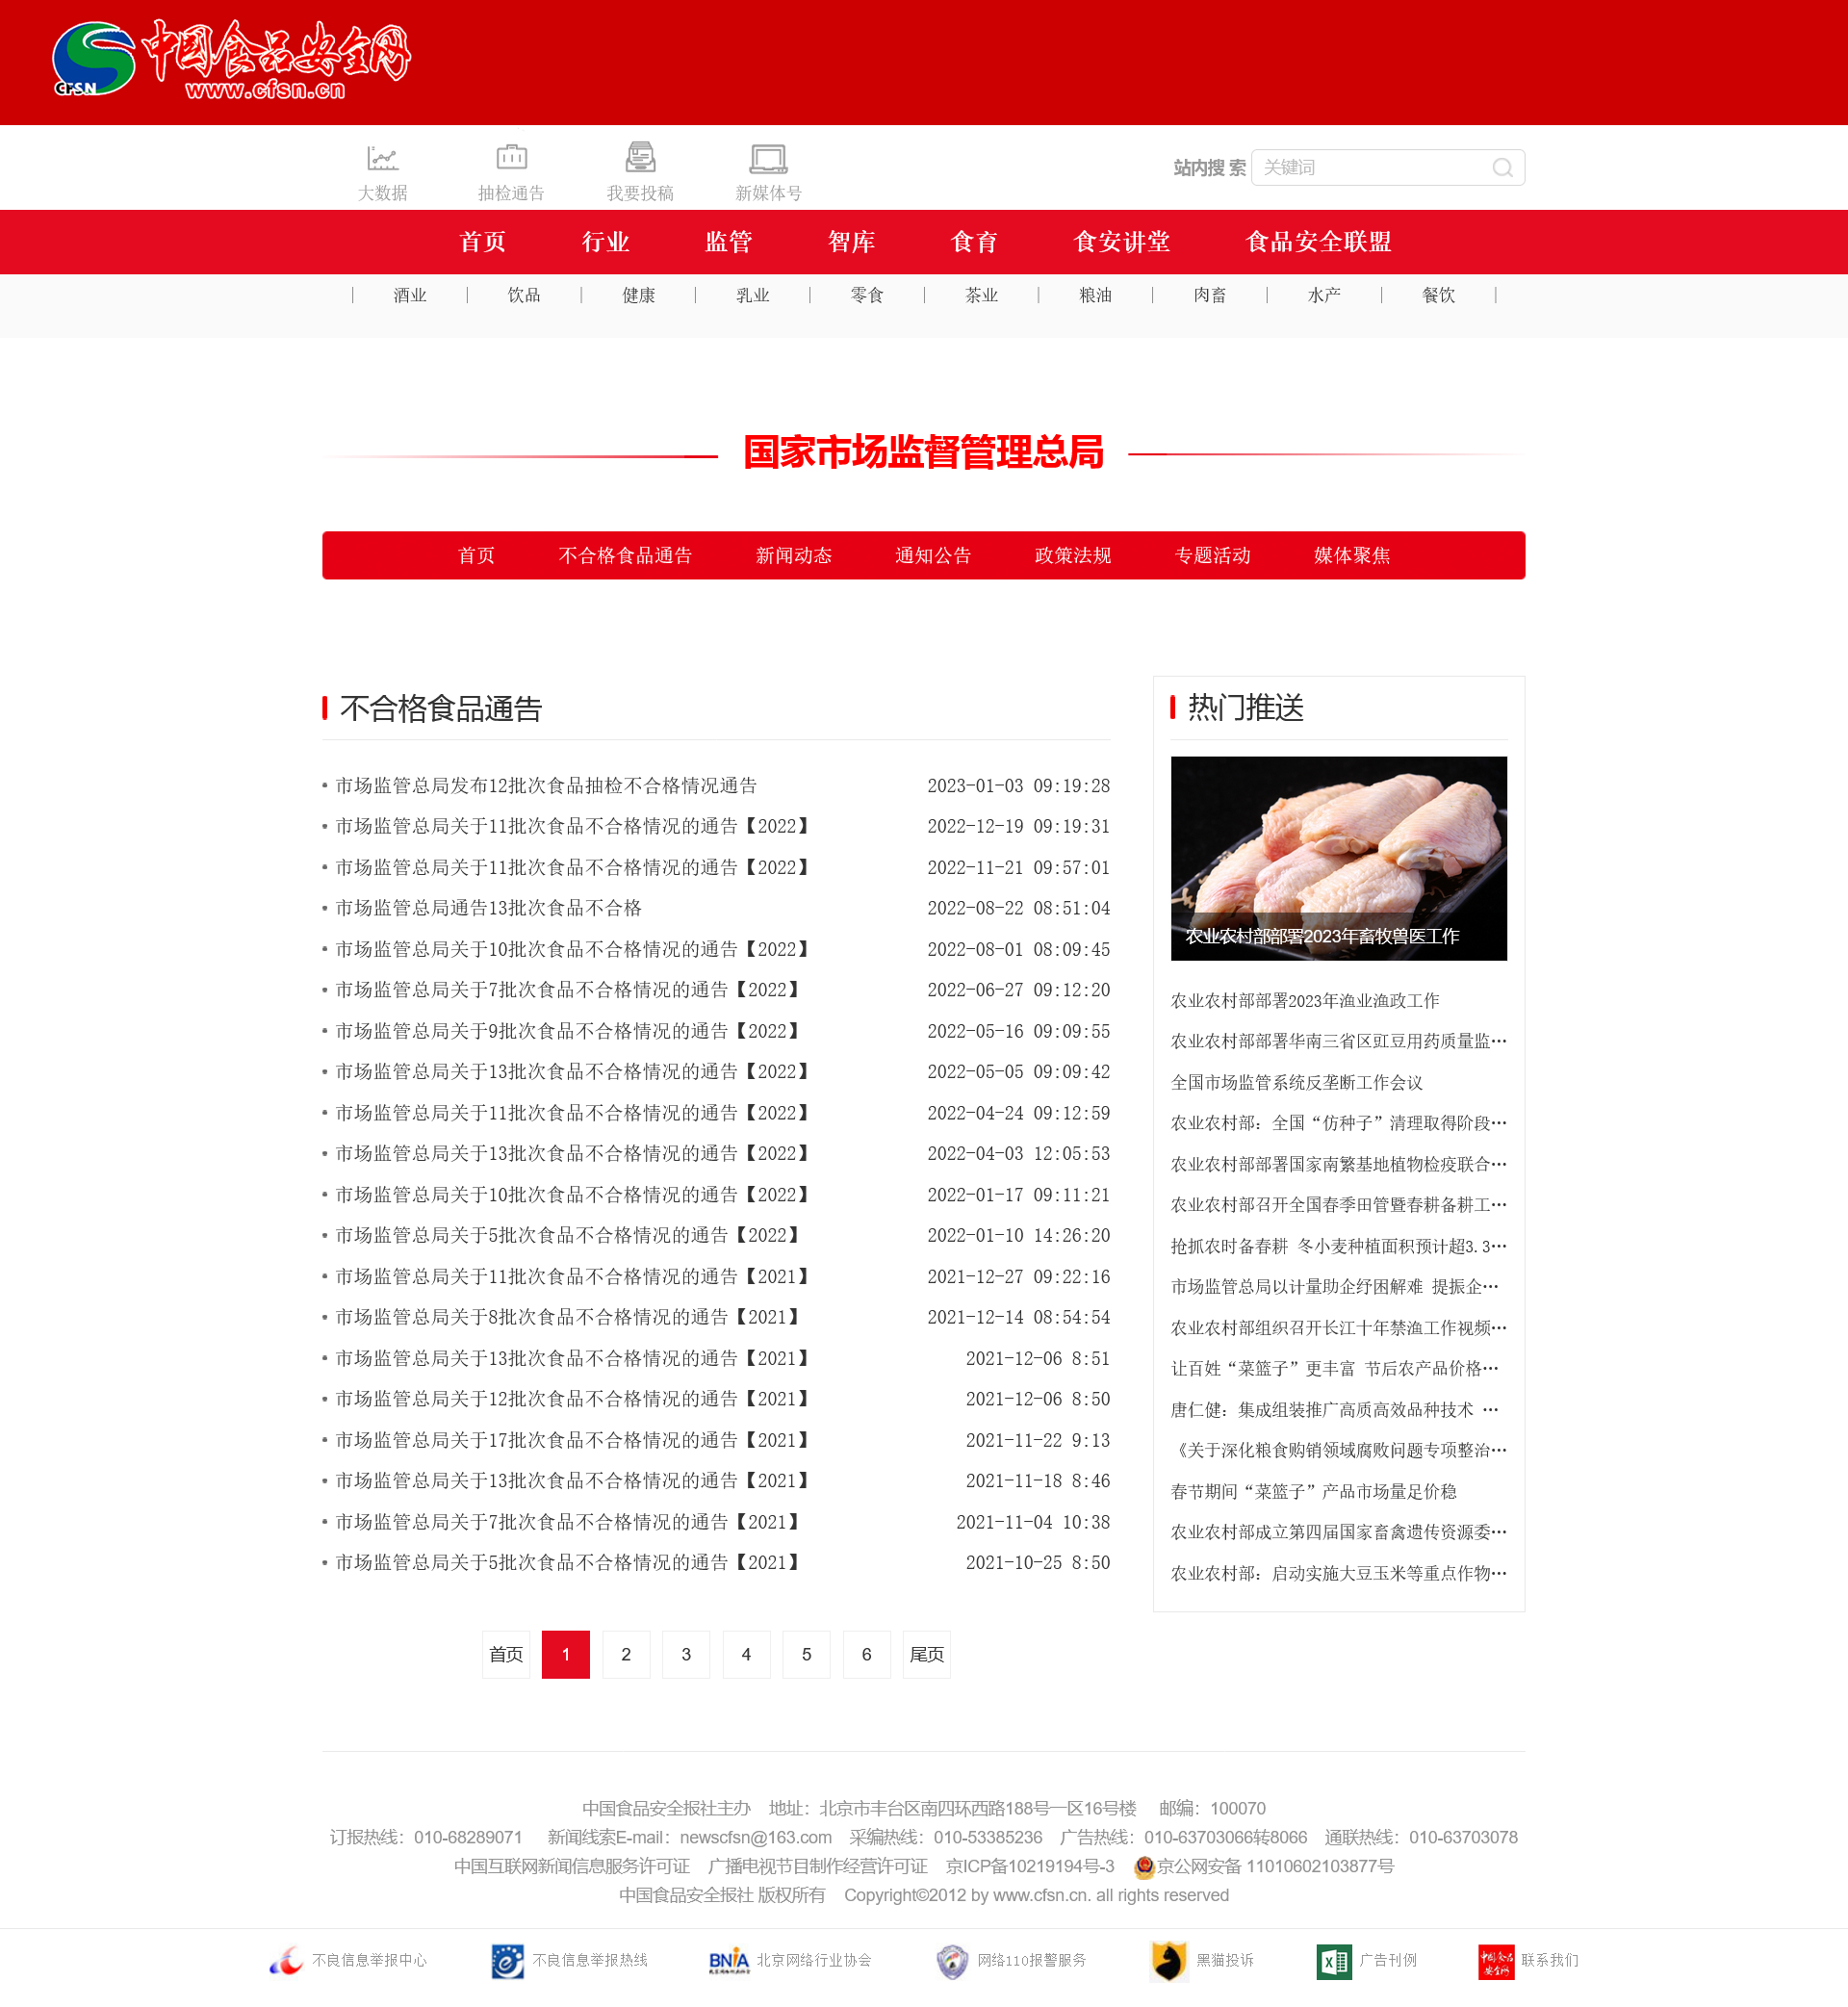

In [7]:
df = spider_multipage('https://www.cfsn.cn/front/web/site.bwnews?bwid=1&bwtypeid=0&page=', 
                      'https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=', 
                      title = '中国食品安全网 - 抽检通告',
                      pages = 10, links = 1000)

1 Visiting: https://www.cfsn.cn/front/web/site.bwnews?bwid=1&bwtypeid=0&page=1
 **Success!**
2 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9934
 **Success!**
3 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9910
 **Success!**
4 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9854
 **Success!**
5 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9581
 **Success!**
6 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9539
 **Success!**
7 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9423
 **Success!**
8 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9271
 **Success!**
9 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9217
 **Success!**
10 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9156
 **Success!**
11 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9014
 **Success!**
12 Vi

 **Success!**
92 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8426
 **Success!**
93 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8427
 **Success!**
94 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8425
 **Success!**
95 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8424
 **Success!**
96 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8422
 **Success!**
97 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8413
 **Success!**
98 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8410
 **Success!**
99 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8420
 **Success!**
100 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8421
 **Success!**
101 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8407
 **Success!**
102 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8

 **Success!**
182 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9186
 **Success!**
183 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9190
 **Success!**
184 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9183
 **Success!**
185 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9182
 **Success!**
186 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9181
 **Success!**
187 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9179
 **Success!**
188 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9175
 **Success!**
189 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9173
 **Success!**
190 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9178
 **Success!**
191 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9170
 **Success!**
192 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
272 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8138
 **Success!**
273 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8134
 **Success!**
274 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8136
 **Success!**
275 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8131
 **Success!**
276 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8129
 **Success!**
277 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8123
 **Success!**
278 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8125
 **Success!**
279 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8061
 **Success!**
280 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8060
 **Success!**
281 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8057
 **Success!**
282 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
362 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8200
 **Success!**
363 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8117
 **Success!**
364 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8114
 **Success!**
365 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8115
 **Success!**
366 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8105
 **Success!**
367 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8111
 **Success!**
368 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8109
 **Success!**
369 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8023
 **Success!**
370 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8026
 **Success!**
371 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8017
 **Success!**
372 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
452 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8884
 **Success!**
453 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8882
 **Success!**
454 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8881
 **Success!**
455 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8883
 **Success!**
456 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8867
 **Success!**
457 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8879
 **Success!**
458 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8878
 **Success!**
459 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8877
 **Success!**
460 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8865
 **Success!**
461 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8864
 **Success!**
462 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
542 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8692
 **Success!**
543 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8689
 **Success!**
544 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8694
 **Success!**
545 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8687
 **Success!**
546 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8686
 **Success!**
547 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8685
 **Success!**
548 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8684
 **Success!**
549 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8682
 **Success!**
550 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8683
 **Success!**
551 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=8680
 **Success!**
552 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
69 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7892
 **Success!**
70 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7823
 **Success!**
71 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7829
 **Success!**
72 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7826
 **Success!**
73 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7827
 **Success!**
74 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7822
 **Success!**
75 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7815
 **Success!**
76 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7813
 **Success!**
77 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7811
 **Success!**
78 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7810
 **Success!**
79 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7804

 **Success!**
159 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7398
 **Success!**
160 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7393
 **Success!**
161 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7390
 **Success!**
162 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7392
 **Success!**
163 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7389
 **Success!**
164 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7325
 **Success!**
165 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7332
 **Success!**
166 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7356
 **Success!**
167 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7324
 **Success!**
168 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7323
 **Success!**
169 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
249 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6902
 **Success!**
250 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6763
 **Success!**
251 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6762
 **Success!**
252 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6760
 **Success!**
253 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6759
 **Success!**
254 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6757
 **Success!**
255 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6755
 **Success!**
256 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6756
 **Success!**
257 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6754
 **Success!**
258 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6750
 **Success!**
259 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
339 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7658
 **Success!**
340 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7655
 **Success!**
341 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7691
 **Success!**
342 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7651
 **Success!**
343 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7648
 **Success!**
344 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7646
 **Success!**
345 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7644
 **Success!**
346 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7643
 **Success!**
347 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7642
 **Success!**
348 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7632
 **Success!**
349 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
429 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7080
 **Success!**
430 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7048
 **Success!**
431 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7051
 **Success!**
432 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7046
 **Success!**
433 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7045
 **Success!**
434 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7042
 **Success!**
435 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7040
 **Success!**
436 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7041
 **Success!**
437 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7038
 **Success!**
438 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7037
 **Success!**
439 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
519 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6565
 **Success!**
520 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6567
 **Success!**
521 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7863
 **Success!**
522 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7881
 **Success!**
523 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7861
 **Success!**
524 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7859
 **Success!**
525 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7857
 **Success!**
526 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7852
 **Success!**
527 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7855
 **Success!**
528 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7856
 **Success!**
529 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
609 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7002
 **Success!**
610 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6944
 **Success!**
611 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6943
 **Success!**
612 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6877
 **Success!**
613 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6875
 **Success!**
614 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6874
 **Success!**
615 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6873
 **Success!**
616 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6871
 **Success!**
617 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6863
 **Success!**
618 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6862
 **Success!**
619 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
699 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7130
 **Success!**
700 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7126
 **Success!**
701 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7122
 **Success!**
702 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7116
 **Success!**
703 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7117
 **Success!**
704 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7125
 **Success!**
705 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7121
 **Success!**
706 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7112
 **Success!**
707 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7115
 **Success!**
708 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=7120
 **Success!**
709 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
789 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6835
 **Success!**
790 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6833
 **Success!**
791 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6824
 **Success!**
792 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6822
 **Success!**
793 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6823
 **Success!**
794 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6826
 **Success!**
795 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6820
 **Success!**
796 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6818
 **Success!**
797 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6816
 **Success!**
798 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6815
 **Success!**
799 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
879 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6319
 **Success!**
880 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6395
 **Success!**
881 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9503
 **Success!**
882 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=9502
 **Success!**
883 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6401
 **Success!**
884 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6400
 **Success!**
885 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6399
 **Success!**
886 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6403
 **Success!**
887 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6397
 **Success!**
888 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6404
 **Success!**
889 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
969 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6356
 **Success!**
970 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6355
 **Success!**
971 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6354
 **Success!**
972 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6353
 **Success!**
973 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6352
 **Success!**
974 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6351
 **Success!**
975 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6350
 **Success!**
976 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6349
 **Success!**
977 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6348
 **Success!**
978 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6255
 **Success!**
979 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
63 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6175
 **Success!**
64 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6178
 **Success!**
65 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6177
 **Success!**
66 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6176
 **Success!**
67 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6170
 **Success!**
68 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6166
 **Success!**
69 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6146
 **Success!**
70 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6144
 **Success!**
71 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6143
 **Success!**
72 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6136
 **Success!**
73 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=6141

 **Success!**
153 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5745
 **Success!**
154 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5743
 **Success!**
155 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5742
 **Success!**
156 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5741
 **Success!**
157 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5706
 **Success!**
158 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5712
 **Success!**
159 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5708
 **Success!**
160 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5703
 **Success!**
161 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5701
 **Success!**
162 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5592
 **Success!**
163 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
243 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5788
 **Success!**
244 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5781
 **Success!**
245 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5782
 **Success!**
246 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5783
 **Success!**
247 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5768
 **Success!**
248 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5778
 **Success!**
249 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5776
 **Success!**
250 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5775
 **Success!**
251 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5773
 **Success!**
252 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5777
 **Success!**
253 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
333 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5636
 **Success!**
334 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5673
 **Success!**
335 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5672
 **Success!**
336 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5671
 **Success!**
337 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5670
 **Success!**
338 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5669
 **Success!**
339 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5608
 **Success!**
340 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5695
 **Success!**
341 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5606
 **Success!**
342 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5605
 **Success!**
343 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
11 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5637
 **Success!**
12 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5640
 **Success!**
13 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5697
 **Success!**
14 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5641
 **Success!**
15 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5683
 **Success!**
16 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5681
 **Success!**
17 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5680
 **Success!**
18 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5679
 **Success!**
19 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5678
 **Success!**
20 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5616
 **Success!**
21 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5615

 **Success!**
101 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5628
 **Success!**
102 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5663
 **Success!**
103 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5662
 **Success!**
104 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5661
 **Success!**
105 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5597
 **Success!**
106 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5660
 **Success!**
107 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5614
 **Success!**
108 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5613
 **Success!**
109 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5612
 **Success!**
110 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5611
 **Success!**
111 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&

 **Success!**
38 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5453
 **Success!**
39 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5606
 **Success!**
40 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5605
 **Success!**
41 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5604
 **Success!**
42 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5668
 **Success!**
43 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5667
 **Success!**
44 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5666
 **Success!**
45 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5665
 **Success!**
46 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5664
 **Success!**
47 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5632
 **Success!**
48 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5700

 **Success!**
128 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5648
 **Success!**
129 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5647
 **Success!**
130 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5622
 **Success!**
131 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5620
 **Success!**
132 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5621
 **Success!**
133 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5452
 **Success!**
1 Visiting: https://www.cfsn.cn/front/web/site.bwnews?bwid=1&bwtypeid=0&page=6
 **Success!**
2 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5606
 **Success!**
3 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5605
 **Success!**
4 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5604
 **Success!**
5 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=

 **Success!**
85 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5396
 **Success!**
86 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5392
 **Success!**
87 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5391
 **Success!**
88 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5387
 **Success!**
89 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5385
 **Success!**
90 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5382
 **Success!**
91 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5379
 **Success!**
92 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5380
 **Success!**
93 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5386
 **Success!**
94 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5372
 **Success!**
95 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5371

 **Success!**
62 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5412
 **Success!**
63 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5414
 **Success!**
64 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5413
 **Success!**
65 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5404
 **Success!**
66 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5399
 **Success!**
67 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5401
 **Success!**
68 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5400
 **Success!**
69 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5396
 **Success!**
70 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5392
 **Success!**
71 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5391
 **Success!**
72 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5387

 **Success!**
59 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5370
 **Success!**
60 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5368
 **Success!**
61 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5366
 **Success!**
62 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5365
 **Success!**
63 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5358
 **Success!**
64 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5357
 **Success!**
65 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5354
 **Success!**
66 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5352
 **Success!**
67 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5349
 **Success!**
68 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5353
 **Success!**
69 Visiting: https://www.cfsn.cn/front/web/site.bwnewshow?bwid=1&newsid=5346

C:\Users\eleve\anaconda3\lib\site-packages\tables\leaf.py:402: PerformanceWarning: The Leaf ``/df/_i_table/content/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


saved to  20230215123447


In [8]:
df

,label,src,url,date,title,content
0,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9934,市场监管总局发布12批次食品抽检不合格情况通告,\n\r\n 摘要：近日，国家市场监督管理总局公布12批次食品...
1,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9910,市场监管总局关于11批次食品不合格情况的通告【2022】,\n\r\n 摘要：近日，国家市场监督管理总局公布11批次食品...
2,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9854,市场监管总局关于11批次食品不合格情况的通告【2022】,\n\r\n 摘要：近日，国家市场监督管理总局公布11批次食品...
3,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9581,市场监管总局通告13批次食品不合格,\n\r\n 摘要：近日，国家市场监督管理总局公布13批次食品...
4,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9539,市场监管总局关于10批次食品不合格情况的通告【2022】,\n\r\n 摘要：近日，国家市场监督管理总局公布10批次食品...
...,...,...,...,...,...,...
1963,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=5647,市场监管总局关于4批次食品不合格情况的通告【2018】,\n\r\n 摘要：2018年4月17日，国家市场监督管理总局...
1964,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=5622,国家市场监管总局关于5批次食品不合格情况的通告【2018】,\n\r\n 摘要：2018年4月9日，国家市场监督管理总局公...
1965,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=5620,国家市场监督管理总局关于7批次食品不合格情况的通告【2018】,\n\r\n 摘要：2018年4月9日，国家市场监督管理总局公...
1966,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=5621,国家市场监督管理总局关于4批次食品不合格情况的通告【2018】,\n\r\n 摘要：2018年4月9日，国家市场监督管理总局公...


## 食安网 > 食品安全专栏

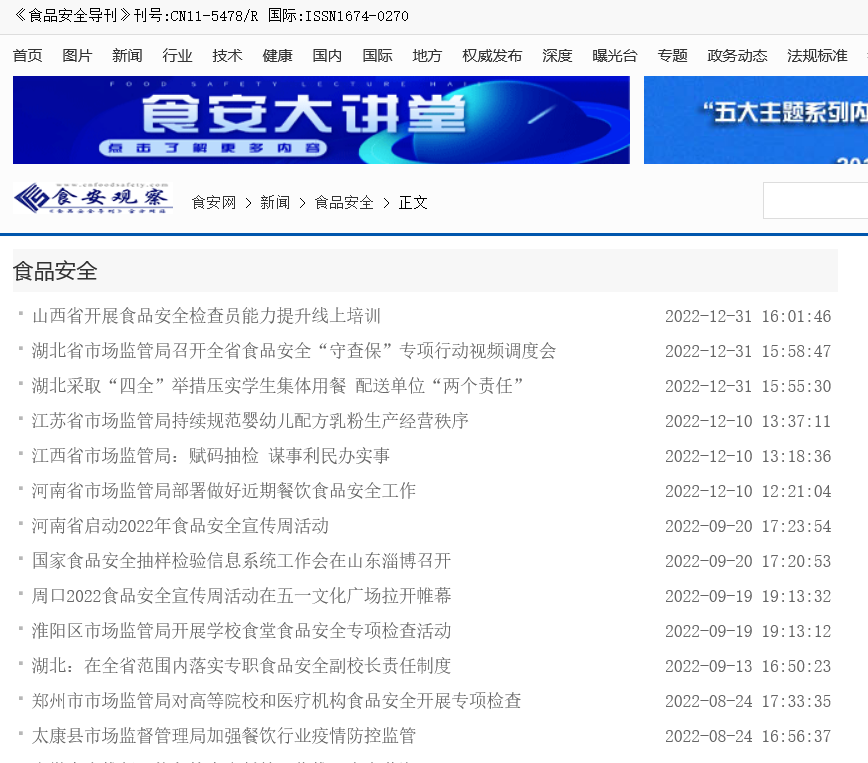

In [9]:
result = map(lambda x: str(x) + '.html', range(2,40))
pages = ['index.html'] + list(result)

df_tmp = spider_multipage('http://www.cnfoodsafety.com/news/spaq/', 
                      'http://www.cnfoodsafety.com/20', 
                      title = '食安网 - 食品安全专栏',
                      pages = pages, links = 100)

df = df.append(df_tmp,ignore_index=True)
df.count()

1 Visiting: http://www.cnfoodsafety.com/news/spaq/index.html
 **Success!**
2 Visiting: http://www.cnfoodsafety.com/2022/1231/68968.html
 **Success!**
3 Visiting: http://www.cnfoodsafety.com/2022/1231/68967.html
 **Success!**
4 Visiting: http://www.cnfoodsafety.com/2022/1231/68966.html
 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2022/1210/68783.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2022/1210/68782.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2022/1210/68781.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2022/0920/67796.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2022/0920/67795.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2022/0919/67783.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2022/0919/67784.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2022/0913/67692.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2022/0824/67361.html
 **Success!**
14 Visiting: http://w

 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2021/1129/62297.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2021/1129/62296.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2021/1129/62295.html
 **Success!**
14 Visiting: http://www.cnfoodsafety.com/2021/1129/62294.html
 **Success!**
15 Visiting: http://www.cnfoodsafety.com/2021/1129/62293.html
 **Success!**
16 Visiting: http://www.cnfoodsafety.com/2021/1129/62292.html
 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2021/1129/62291.html
 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2021/1129/62290.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2021/1129/62289.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2021/1129/62288.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2021/1129/62287.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2021/1129/62286.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2021/1129/62285.html
 **Success!*

 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2021/1018/61322.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2021/1018/61321.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2021/1018/61320.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2021/1018/61319.html
 **Success!**
24 Visiting: http://www.cnfoodsafety.com/2021/1018/61318.html
 **Success!**
25 Visiting: http://www.cnfoodsafety.com/2021/1018/61317.html
 **Success!**
26 Visiting: http://www.cnfoodsafety.com/2021/1018/61316.html
 **Success!**
27 Visiting: http://www.cnfoodsafety.com/2021/1018/61315.html
 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2021/1018/61314.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2021/1018/61313.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2021/1018/61312.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2021/1018/61311.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2021/1018/61310.html
 **Success!*

 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2021/1011/61063.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2021/1011/61062.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2021/1011/61061.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2021/1011/61060.html
 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2021/1011/61059.html
 **Success!**
34 Visiting: http://www.cnfoodsafety.com/2021/1011/61057.html
 **Success!**
35 Visiting: http://www.cnfoodsafety.com/2021/1011/61056.html
 **Success!**
36 Visiting: http://www.cnfoodsafety.com/2021/1011/61055.html
 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2021/1011/61054.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2021/1011/61053.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2021/1011/61052.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2021/1011/61051.html
 **Success!**
41 Visiting: http://www.cnfoodsafety.com/2021/1011/61050.html
 **Success!*

 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2021/0830/60206.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2021/0830/60204.html
 **Success!**
41 Visiting: http://www.cnfoodsafety.com/2021/0830/60203.html
 **Success!**
42 Visiting: http://www.cnfoodsafety.com/2021/0830/60202.html
 **Success!**
43 Visiting: http://www.cnfoodsafety.com/2021/0830/60201.html
 **Success!**
44 Visiting: http://www.cnfoodsafety.com/2021/0830/60200.html
 **Success!**
45 Visiting: http://www.cnfoodsafety.com/2021/0830/60199.html
 **Success!**
46 Visiting: http://www.cnfoodsafety.com/2021/0830/60198.html
 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2021/0830/60197.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2021/0830/60196.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2021/0830/60195.html
 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2021/0830/60194.html
 **Success!**
51 Visiting: http://www.cnfoodsafety.com/2021/0830/60193.html
 **Success!*

 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2021/0818/59792.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2021/0818/59780.html
 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2021/0817/59767.html
 **Success!**
51 Visiting: http://www.cnfoodsafety.com/2021/0817/59766.html
 **Success!**
52 Visiting: http://www.cnfoodsafety.com/2021/0817/59765.html
 **Success!**
53 Visiting: http://www.cnfoodsafety.com/2021/0817/59764.html
 **Success!**
54 Visiting: http://www.cnfoodsafety.com/2021/0817/59763.html
 **Success!**
55 Visiting: http://www.cnfoodsafety.com/2021/0817/59762.html
 **Success!**
56 Visiting: http://www.cnfoodsafety.com/2021/0817/59761.html
 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2021/0817/59760.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2021/0817/59759.html
 **Success!**
59 Visiting: http://www.cnfoodsafety.com/2021/0817/59758.html
 **Success!**
60 Visiting: http://www.cnfoodsafety.com/2021/0817/59757.html
 **Success!*

 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2021/0630/58475.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2021/0630/58473.html
 **Success!**
59 Visiting: http://www.cnfoodsafety.com/2021/0630/58472.html
 **Success!**
60 Visiting: http://www.cnfoodsafety.com/2021/0630/58470.html
 **Success!**
61 Visiting: http://www.cnfoodsafety.com/2021/0630/58469.html
 **Success!**
62 Visiting: http://www.cnfoodsafety.com/2021/0630/58467.html
 **Success!**
63 Visiting: http://www.cnfoodsafety.com/2021/0630/58466.html
 **Success!**
64 Visiting: http://www.cnfoodsafety.com/2021/0622/58261.html
 **Success!**
65 Visiting: http://www.cnfoodsafety.com/2021/0621/58198.html
 **Success!**
66 Visiting: http://www.cnfoodsafety.com/2021/1014/61206.html
 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!*

 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!**
70 Visiting: http://www.cnfoodsafety.com/2021/0804/59311.html
 **Success!**
71 Visiting: http://www.cnfoodsafety.com/2021/1108/61754.html
 **Success!**
72 Visiting: http://www.cnfoodsafety.com/2021/1011/61026.html
 **Success!**
73 Visiting: http://www.cnfoodsafety.com/2015/0803/13641.html
 **Success!**
74 Visiting: http://www.cnfoodsafety.com/2014/0806/2011.html
 **Success!**
75 Visiting: http://www.cnfoodsafety.com/2015/0909/14624.html
 **Success!**
76 Visiting: http://www.cnfoodsafety.com/2016/1101/21015.html
 **Success!**
77 Visiting: http://www.cnfoodsafety.com/2015/1207/16097.html
 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2015/0605/12117.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2017/0413/23020.html
 **Success!**

 **Success!**
77 Visiting: http://www.cnfoodsafety.com/2015/1207/16097.html
 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2015/0605/12117.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2017/0413/23020.html
 **Success!**
80 Visiting: http://www.cnfoodsafety.com/2017/1127/25429.html
 **Success!**
81 Visiting: http://www.cnfoodsafety.com/2014/0626/878.html
 **Success!**
82 Visiting: http://www.cnfoodsafety.com/2014/0910/3631.html
 **Success!**
83 Visiting: http://www.cnfoodsafety.com/2020/1127/53806.html
 **Success!**
84 Visiting: http://www.cnfoodsafety.com/2020/0203/47938.html
 **Success!**
85 Visiting: http://www.cnfoodsafety.com/2016/1024/20934.html
 **Success!**
86 Visiting: http://www.cnfoodsafety.com/2015/1009/15075.html
 **Success!**
87 Visiting: http://www.cnfoodsafety.com/2015/1009/15074.html
 **Success!**
88 Visiting: http://www.cnfoodsafety.com/2015/0831/14413.html
 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2018/1026/33325.html
 **Success!**
9

 **Success!**
86 Visiting: http://www.cnfoodsafety.com/2015/1009/15075.html
 **Success!**
87 Visiting: http://www.cnfoodsafety.com/2015/1009/15074.html
 **Success!**
88 Visiting: http://www.cnfoodsafety.com/2015/0831/14413.html
 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2018/1026/33325.html
 **Success!**
90 Visiting: http://www.cnfoodsafety.com/2018/1010/32383.html
 **Success!**
91 Visiting: http://www.cnfoodsafety.com/2018/0831/30527.html
 **Success!**
92 Visiting: http://www.cnfoodsafety.com/2015/0730/13573.html
 **Success!**
93 Visiting: http://www.cnfoodsafety.com/2015/0324/9872.html
 **Success!**
94 Visiting: http://www.cnfoodsafety.com/2015/0214/9051.html
 **Success!**
95 Visiting: http://www.cnfoodsafety.com/2018/0919/31523.html
 **Success!**
96 Visiting: http://www.cnfoodsafety.com/2020/1021/53091.html
 **Success!**
97 Visiting: http://www.cnfoodsafety.com/2020/0521/50135.html
 **Success!**
98 Visiting: http://www.cnfoodsafety.com/2020/0818/51806.html
 **Success!**


 **Success!**
96 Visiting: http://www.cnfoodsafety.com/2020/0630/50966.html
 **Success!**
97 Visiting: http://www.cnfoodsafety.com/2020/0521/50135.html
 **Success!**
98 Visiting: http://www.cnfoodsafety.com/2020/0203/47928.html
 **Success!**
99 Visiting: http://www.cnfoodsafety.com/2019/0805/43801.html
 **Success!**
100 Visiting: http://www.cnfoodsafety.com/2019/0701/42826.html
 **Success!**
1 Visiting: http://www.cnfoodsafety.com/news/spaq/12.html
 **Success!**
2 Visiting: http://www.cnfoodsafety.com/2020/0526/50237.html
 **Success!**
3 Visiting: http://www.cnfoodsafety.com/2020/0526/50236.html
 **Success!**
4 Visiting: http://www.cnfoodsafety.com/2020/0526/50235.html
 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2020/0526/50234.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2020/0526/50233.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2020/0526/50232.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2020/0526/50231.html
 **Success!**
9 Visiti

 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2019/1225/47296.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2019/1225/47295.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2019/1225/47294.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2019/1225/47293.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2019/1225/47292.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2019/1225/47291.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2019/1225/47290.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2019/1225/47289.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2019/1126/46692.html
 **Success!**
14 Visiting: http://www.cnfoodsafety.com/2019/1126/46691.html
 **Success!**
15 Visiting: http://www.cnfoodsafety.com/2019/1126/46690.html
 **Success!**
16 Visiting: http://www.cnfoodsafety.com/2019/1126/46689.html
 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2019/1126/46688.html
 **Success!**
18 

 **Success!**
14 Visiting: http://www.cnfoodsafety.com/2019/0828/44459.html
 **Success!**
15 Visiting: http://www.cnfoodsafety.com/2019/0828/44437.html
 **Success!**
16 Visiting: http://www.cnfoodsafety.com/2019/0828/44436.html
 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2019/0828/44435.html
 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2019/0828/44434.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2019/0828/44433.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2019/0828/44432.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2019/0828/44431.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2019/0828/44430.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2019/0828/44428.html
 **Success!**
24 Visiting: http://www.cnfoodsafety.com/2019/0828/44427.html
 **Success!**
25 Visiting: http://www.cnfoodsafety.com/2019/0819/44151.html
 **Success!**
26 Visiting: http://www.cnfoodsafety.com/2019/0815/44074.html
 **Success!*

 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2019/0620/42508.html
 **Success!**
24 Visiting: http://www.cnfoodsafety.com/2019/0620/42507.html
 **Success!**
25 Visiting: http://www.cnfoodsafety.com/2019/0619/42469.html
 **Success!**
26 Visiting: http://www.cnfoodsafety.com/2019/0619/42466.html
 **Success!**
27 Visiting: http://www.cnfoodsafety.com/2019/0618/42418.html
 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2019/0606/42219.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2019/0606/42218.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2019/0606/42217.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2019/0605/42171.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2019/0605/42170.html
 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2019/0605/42169.html
 **Success!**
34 Visiting: http://www.cnfoodsafety.com/2019/0605/42168.html
 **Success!**
35 Visiting: http://www.cnfoodsafety.com/2019/0605/42167.html
 **Success!*

 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2018/1226/36207.html
 **Success!**
34 Visiting: http://www.cnfoodsafety.com/2018/1226/36206.html
 **Success!**
35 Visiting: http://www.cnfoodsafety.com/2018/1226/36205.html
 **Success!**
36 Visiting: http://www.cnfoodsafety.com/2018/1226/36203.html
 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2018/1226/36202.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2018/1226/36200.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2018/1127/34930.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2018/1127/34929.html
 **Success!**
41 Visiting: http://www.cnfoodsafety.com/2018/1127/34927.html
 **Success!**
42 Visiting: http://www.cnfoodsafety.com/2018/1127/34926.html
 **Success!**
43 Visiting: http://www.cnfoodsafety.com/2018/1127/34925.html
 **Success!**
44 Visiting: http://www.cnfoodsafety.com/2018/1126/34851.html
 **Success!**
45 Visiting: http://www.cnfoodsafety.com/2018/1126/34850.html
 **Success!*

 **Success!**
43 Visiting: http://www.cnfoodsafety.com/2018/0801/29013.html
 **Success!**
44 Visiting: http://www.cnfoodsafety.com/2018/0801/29011.html
 **Success!**
45 Visiting: http://www.cnfoodsafety.com/2018/0801/29010.html
 **Success!**
46 Visiting: http://www.cnfoodsafety.com/2018/0731/28894.html
 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2018/0731/28890.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2018/0731/28887.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2018/0726/28734.html
 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2018/0720/28527.html
 **Success!**
51 Visiting: http://www.cnfoodsafety.com/2018/0627/27823.html
 **Success!**
52 Visiting: http://www.cnfoodsafety.com/2018/0627/27822.html
 **Success!**
53 Visiting: http://www.cnfoodsafety.com/2018/0627/27821.html
 **Success!**
54 Visiting: http://www.cnfoodsafety.com/2018/0627/27819.html
 **Success!**
55 Visiting: http://www.cnfoodsafety.com/2018/0627/27818.html
 **Success!*

 **Success!**
52 Visiting: http://www.cnfoodsafety.com/2018/0327/26588.html
 **Success!**
53 Visiting: http://www.cnfoodsafety.com/2018/0327/26587.html
 **Success!**
54 Visiting: http://www.cnfoodsafety.com/2018/0327/26572.html
 **Success!**
55 Visiting: http://www.cnfoodsafety.com/2018/0327/26571.html
 **Success!**
56 Visiting: http://www.cnfoodsafety.com/2018/0327/26570.html
 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2018/0327/26569.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2018/0327/26567.html
 **Success!**
59 Visiting: http://www.cnfoodsafety.com/2018/0327/26566.html
 **Success!**
60 Visiting: http://www.cnfoodsafety.com/2018/0319/26486.html
 **Success!**
61 Visiting: http://www.cnfoodsafety.com/2018/0319/26480.html
 **Success!**
62 Visiting: http://www.cnfoodsafety.com/2018/0315/26453.html
 **Success!**
63 Visiting: http://www.cnfoodsafety.com/2018/0313/26439.html
 **Success!**
64 Visiting: http://www.cnfoodsafety.com/2018/0313/26438.html
 **Success!*

 **Success!**
61 Visiting: http://www.cnfoodsafety.com/2017/1220/25697.html
 **Success!**
62 Visiting: http://www.cnfoodsafety.com/2017/1220/25696.html
 **Success!**
63 Visiting: http://www.cnfoodsafety.com/2017/1219/25689.html
 **Success!**
64 Visiting: http://www.cnfoodsafety.com/2017/1219/25687.html
 **Success!**
65 Visiting: http://www.cnfoodsafety.com/2017/1218/25682.html
 **Success!**
66 Visiting: http://www.cnfoodsafety.com/2021/1014/61206.html
 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!**
70 Visiting: http://www.cnfoodsafety.com/2021/0804/59311.html
 **Success!**
71 Visiting: http://www.cnfoodsafety.com/2021/1108/61754.html
 **Success!**
72 Visiting: http://www.cnfoodsafety.com/2021/1011/61026.html
 **Success!**
73 Visiting: http://www.cnfoodsafety.com/2015/0803/13641.html
 **Success!*

 **Success!**
70 Visiting: http://www.cnfoodsafety.com/2021/0804/59311.html
 **Success!**
71 Visiting: http://www.cnfoodsafety.com/2021/1108/61754.html
 **Success!**
72 Visiting: http://www.cnfoodsafety.com/2021/1011/61026.html
 **Success!**
73 Visiting: http://www.cnfoodsafety.com/2015/0803/13641.html
 **Success!**
74 Visiting: http://www.cnfoodsafety.com/2014/0806/2011.html
 **Success!**
75 Visiting: http://www.cnfoodsafety.com/2015/0909/14624.html
 **Success!**
76 Visiting: http://www.cnfoodsafety.com/2016/1101/21015.html
 **Success!**
77 Visiting: http://www.cnfoodsafety.com/2015/1207/16097.html
 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2015/0605/12117.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2017/0413/23020.html
 **Success!**
80 Visiting: http://www.cnfoodsafety.com/2014/0626/878.html
 **Success!**
81 Visiting: http://www.cnfoodsafety.com/2014/0910/3631.html
 **Success!**
82 Visiting: http://www.cnfoodsafety.com/2020/1127/53806.html
 **Success!**
83

 **Success!**
80 Visiting: http://www.cnfoodsafety.com/2014/0626/878.html
 **Success!**
81 Visiting: http://www.cnfoodsafety.com/2014/0910/3631.html
 **Success!**
82 Visiting: http://www.cnfoodsafety.com/2020/1127/53806.html
 **Success!**
83 Visiting: http://www.cnfoodsafety.com/2020/0203/47938.html
 **Success!**
84 Visiting: http://www.cnfoodsafety.com/2016/1024/20934.html
 **Success!**
85 Visiting: http://www.cnfoodsafety.com/2015/1009/15075.html
 **Success!**
86 Visiting: http://www.cnfoodsafety.com/2015/1009/15074.html
 **Success!**
87 Visiting: http://www.cnfoodsafety.com/2015/0831/14413.html
 **Success!**
88 Visiting: http://www.cnfoodsafety.com/2015/0724/13350.html
 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2016/0823/19996.html
 **Success!**
90 Visiting: http://www.cnfoodsafety.com/2016/0926/20587.html
 **Success!**
91 Visiting: http://www.cnfoodsafety.com/2015/0730/13573.html
 **Success!**
92 Visiting: http://www.cnfoodsafety.com/2015/0324/9872.html
 **Success!**
93

 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2015/0112/8304.html
 **Success!**
90 Visiting: http://www.cnfoodsafety.com/2015/0602/11944.html
 **Success!**
91 Visiting: http://www.cnfoodsafety.com/2015/0730/13573.html
 **Success!**
92 Visiting: http://www.cnfoodsafety.com/2015/0324/9872.html
 **Success!**
93 Visiting: http://www.cnfoodsafety.com/2015/0214/9051.html
 **Success!**
94 Visiting: http://www.cnfoodsafety.com/2014/0710/1165.html
 **Success!**
95 Visiting: http://www.cnfoodsafety.com/2014/0709/1162.html
 **Success!**
96 Visiting: http://www.cnfoodsafety.com/2017/0307/22653.html
 **Success!**
97 Visiting: http://www.cnfoodsafety.com/2017/0307/22652.html
 **Success!**
98 Visiting: http://www.cnfoodsafety.com/2017/0103/21961.html
 **Success!**
99 Visiting: http://www.cnfoodsafety.com/2016/1230/21953.html
 **Success!**
100 Visiting: http://www.cnfoodsafety.com/2016/1229/21951.html
 **Success!**
1 Visiting: http://www.cnfoodsafety.com/news/spaq/23.html
 **Success!**
2 Visi

 **Success!**
99 Visiting: http://www.cnfoodsafety.com/2016/1008/20739.html
 **Success!**
100 Visiting: http://www.cnfoodsafety.com/2016/0812/19861.html
 **Success!**
1 Visiting: http://www.cnfoodsafety.com/news/spaq/24.html
 **Success!**
2 Visiting: http://www.cnfoodsafety.com/2016/0606/18915.html
 **Success!**
3 Visiting: http://www.cnfoodsafety.com/2016/0603/18913.html
 **Success!**
4 Visiting: http://www.cnfoodsafety.com/2016/0602/18909.html
 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2016/0526/18709.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2016/0520/18627.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2016/0520/18626.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2016/0520/18625.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2016/0520/18624.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2016/0520/18623.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2016/0520/18622.html
 **Success!**
12 Visiti

 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2015/1207/16131.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2015/1207/16125.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2015/1207/16124.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2015/1207/16122.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2015/1207/16097.html
 **Success!**
14 Visiting: http://www.cnfoodsafety.com/2015/1204/16067.html
 **Success!**
15 Visiting: http://www.cnfoodsafety.com/2015/1202/16036.html
 **Success!**
16 Visiting: http://www.cnfoodsafety.com/2015/1130/15999.html
 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2015/1126/15922.html
 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2015/1123/15882.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2015/1122/15827.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2015/1122/15826.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2015/1122/15825.html
 **Success!**

 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2015/0907/14580.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2015/0906/14539.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2015/0906/14528.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2015/0906/14517.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2015/0902/14491.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2015/0902/14470.html
 **Success!**
24 Visiting: http://www.cnfoodsafety.com/2015/0831/14425.html
 **Success!**
25 Visiting: http://www.cnfoodsafety.com/2015/0828/14387.html
 **Success!**
26 Visiting: http://www.cnfoodsafety.com/2015/0828/14384.html
 **Success!**
27 Visiting: http://www.cnfoodsafety.com/2015/0828/14383.html
 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2015/0828/14379.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2015/0827/14366.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2015/0827/14365.html
 **Success!*

 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2015/0721/13161.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2015/0720/13132.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2015/0720/13131.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2015/0710/12998.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2015/0709/12969.html
 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2015/0708/12903.html
 **Success!**
34 Visiting: http://www.cnfoodsafety.com/2015/0707/12861.html
 **Success!**
35 Visiting: http://www.cnfoodsafety.com/2015/0707/12855.html
 **Success!**
36 Visiting: http://www.cnfoodsafety.com/2015/0706/12832.html
 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2015/0703/12800.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2015/0703/12797.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2015/0702/12774.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2015/0702/12769.html
 **Success!*

 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2015/0520/11413.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2015/0520/11412.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2015/0520/11411.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2015/0519/11382.html
 **Success!**
41 Visiting: http://www.cnfoodsafety.com/2015/0519/11368.html
 **Success!**
42 Visiting: http://www.cnfoodsafety.com/2015/0519/11366.html
 **Success!**
43 Visiting: http://www.cnfoodsafety.com/2015/0518/11334.html
 **Success!**
44 Visiting: http://www.cnfoodsafety.com/2015/0518/11328.html
 **Success!**
45 Visiting: http://www.cnfoodsafety.com/2015/0515/11283.html
 **Success!**
46 Visiting: http://www.cnfoodsafety.com/2015/0515/11278.html
 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2015/0514/11231.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2015/0514/11230.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2015/0513/11188.html
 **Success!*

 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2015/0326/10031.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2015/0326/10030.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2015/0326/10027.html
 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2015/0325/9978.html
 **Success!**
51 Visiting: http://www.cnfoodsafety.com/2015/0325/9956.html
 **Success!**
52 Visiting: http://www.cnfoodsafety.com/2015/0325/9897.html
 **Success!**
53 Visiting: http://www.cnfoodsafety.com/2015/0325/9896.html
 **Success!**
54 Visiting: http://www.cnfoodsafety.com/2015/0324/9866.html
 **Success!**
55 Visiting: http://www.cnfoodsafety.com/2015/0324/9858.html
 **Success!**
56 Visiting: http://www.cnfoodsafety.com/2015/0324/9857.html
 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2015/0324/9847.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2015/0323/9812.html
 **Success!**
59 Visiting: http://www.cnfoodsafety.com/2015/0323/9811.html
 **Success!**
60 Visit

 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2015/0127/8661.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2015/0126/8616.html
 **Success!**
59 Visiting: http://www.cnfoodsafety.com/2015/0126/8614.html
 **Success!**
60 Visiting: http://www.cnfoodsafety.com/2015/0123/8585.html
 **Success!**
61 Visiting: http://www.cnfoodsafety.com/2015/0122/8568.html
 **Success!**
62 Visiting: http://www.cnfoodsafety.com/2015/0122/8566.html
 **Success!**
63 Visiting: http://www.cnfoodsafety.com/2015/0122/8564.html
 **Success!**
64 Visiting: http://www.cnfoodsafety.com/2015/0122/8562.html
 **Success!**
65 Visiting: http://www.cnfoodsafety.com/2015/0122/8560.html
 **Success!**
66 Visiting: http://www.cnfoodsafety.com/2021/1014/61206.html
 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!**
70 Visi

 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!**
70 Visiting: http://www.cnfoodsafety.com/2021/0804/59311.html
 **Success!**
71 Visiting: http://www.cnfoodsafety.com/2021/1108/61754.html
 **Success!**
72 Visiting: http://www.cnfoodsafety.com/2021/1011/61026.html
 **Success!**
73 Visiting: http://www.cnfoodsafety.com/2015/0803/13641.html
 **Success!**
74 Visiting: http://www.cnfoodsafety.com/2014/0806/2011.html
 **Success!**
75 Visiting: http://www.cnfoodsafety.com/2015/0909/14624.html
 **Success!**
76 Visiting: http://www.cnfoodsafety.com/2016/1101/21015.html
 **Success!**
77 Visiting: http://www.cnfoodsafety.com/2015/1207/16097.html
 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2015/0605/12117.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2017/0413/23020.html
 **Success!**

 **Success!**
77 Visiting: http://www.cnfoodsafety.com/2015/1207/16097.html
 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2015/0605/12117.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2017/0413/23020.html
 **Success!**
80 Visiting: http://www.cnfoodsafety.com/2017/1127/25429.html
 **Success!**
81 Visiting: http://www.cnfoodsafety.com/2014/0626/878.html
 **Success!**
82 Visiting: http://www.cnfoodsafety.com/2014/0910/3631.html
 **Success!**
83 Visiting: http://www.cnfoodsafety.com/2020/1127/53806.html
 **Success!**
84 Visiting: http://www.cnfoodsafety.com/2020/0203/47938.html
 **Success!**
85 Visiting: http://www.cnfoodsafety.com/2016/1024/20934.html
 **Success!**
86 Visiting: http://www.cnfoodsafety.com/2015/1009/15075.html
 **Success!**
87 Visiting: http://www.cnfoodsafety.com/2015/1009/15074.html
 **Success!**
88 Visiting: http://www.cnfoodsafety.com/2015/0831/14413.html
 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2014/0928/4570.html
 **Success!**
90

 **Success!**
87 Visiting: http://www.cnfoodsafety.com/2015/1009/15074.html
 **Success!**
88 Visiting: http://www.cnfoodsafety.com/2015/0831/14413.html
 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2014/0616/150.html
 **Success!**
90 Visiting: http://www.cnfoodsafety.com/2014/0616/160.html
 **Success!**
91 Visiting: http://www.cnfoodsafety.com/2014/0616/162.html
 **Success!**
92 Visiting: http://www.cnfoodsafety.com/2014/0617/277.html
 **Success!**
93 Visiting: http://www.cnfoodsafety.com/2014/0617/278.html
 **Success!**
94 Visiting: http://www.cnfoodsafety.com/2015/0730/13573.html
 **Success!**
95 Visiting: http://www.cnfoodsafety.com/2015/0324/9872.html
 **Success!**
96 Visiting: http://www.cnfoodsafety.com/2015/0214/9051.html
 **Success!**
97 Visiting: http://www.cnfoodsafety.com/2014/1027/5471.html
 **Failed!**
98 Visiting: http://www.cnfoodsafety.com/2014/0710/1165.html
 **Success!**
99 Visiting: http://www.cnfoodsafety.com/2014/0709/1162.html
 **Success!**
100 Visiting: 

 **Success!**
97 Visiting: http://www.cnfoodsafety.com/2014/1027/5471.html
 **Failed!**
98 Visiting: http://www.cnfoodsafety.com/2014/0710/1165.html
 **Success!**
99 Visiting: http://www.cnfoodsafety.com/2014/0709/1162.html
 **Success!**
100 Visiting: http://www.cnfoodsafety.com/2015/0915/14682.html
 **Success!**
1 Visiting: http://www.cnfoodsafety.com/news/spaq/35.html
 **Success!**
2 Visiting: http://www.cnfoodsafety.com/2014/1014/5032.html
 **Success!**
3 Visiting: http://www.cnfoodsafety.com/2014/1014/5031.html
 **Success!**
4 Visiting: http://www.cnfoodsafety.com/2014/1014/5030.html
 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2014/1014/5029.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2014/1014/5021.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2014/1014/5016.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2014/1014/5015.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2014/1014/5014.html
 **Success!**
10 Visiting: http://w

 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2014/0925/4352.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2014/0925/4340.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2014/0925/4329.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2014/0925/4320.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2014/0923/4264.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2014/0923/4261.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2014/0923/4260.html
 **Success!**
14 Visiting: http://www.cnfoodsafety.com/2014/0923/4259.html
 **Success!**
15 Visiting: http://www.cnfoodsafety.com/2014/0923/4258.html
 **Success!**
16 Visiting: http://www.cnfoodsafety.com/2014/0923/4257.html
 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2014/0923/4231.html
 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2014/0922/4160.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2014/0922/4150.html
 **Success!**
20 Visiting: h

 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2014/0902/3187.html
 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2014/0902/3180.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2014/0829/3063.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2014/0829/3062.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2014/0829/3032.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2014/0829/3020.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2014/0826/2944.html
 **Success!**
24 Visiting: http://www.cnfoodsafety.com/2014/0826/2943.html
 **Success!**
25 Visiting: http://www.cnfoodsafety.com/2014/0825/2929.html
 **Success!**
26 Visiting: http://www.cnfoodsafety.com/2014/0825/2928.html
 **Success!**
27 Visiting: http://www.cnfoodsafety.com/2014/0822/2875.html
 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2014/0822/2852.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2014/0821/2744.html
 **Success!**
30 Visiting

 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2014/0626/854.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2014/0625/840.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2014/0625/839.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2014/0625/838.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2014/0625/837.html
 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2014/0625/836.html
 **Success!**
34 Visiting: http://www.cnfoodsafety.com/2014/0617/284.html
 **Success!**
35 Visiting: http://www.cnfoodsafety.com/2014/0617/283.html
 **Success!**
36 Visiting: http://www.cnfoodsafety.com/2014/0617/282.html
 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2014/0617/281.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2014/0617/280.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2014/0617/279.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2014/0617/278.html
 **Success!**
41 Visiting: http://www.

 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2015/0324/9872.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2015/0214/9051.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2014/1027/5471.html
 **Failed!**
41 Visiting: http://www.cnfoodsafety.com/2014/0710/1165.html
 **Success!**
42 Visiting: http://www.cnfoodsafety.com/2014/0709/1162.html
 **Success!**
43 Visiting: http://www.cnfoodsafety.com/2015/0915/14682.html
 **Success!**
44 Visiting: http://www.cnfoodsafety.com/2015/0825/14313.html
 **Success!**
45 Visiting: http://www.cnfoodsafety.com/2015/0825/14294.html
 **Success!**
46 Visiting: http://www.cnfoodsafety.com/2015/0820/14149.html
 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2015/0820/14148.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2015/0820/14147.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2015/0820/14146.html
 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2015/0820/14140.html
 **Success!**
51 V

C:\Users\eleve\anaconda3\lib\site-packages\tables\leaf.py:402: PerformanceWarning: The Leaf ``/df/_i_table/content/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


saved to  20230215123447


C:\Users\eleve\AppData\Local\Temp\ipykernel_8204\1108454576.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp,ignore_index=True)


label      4450
src        4450
url        4450
date       4450
title      4450
content    4450
dtype: int64

## 食安网 > 曝光台专栏

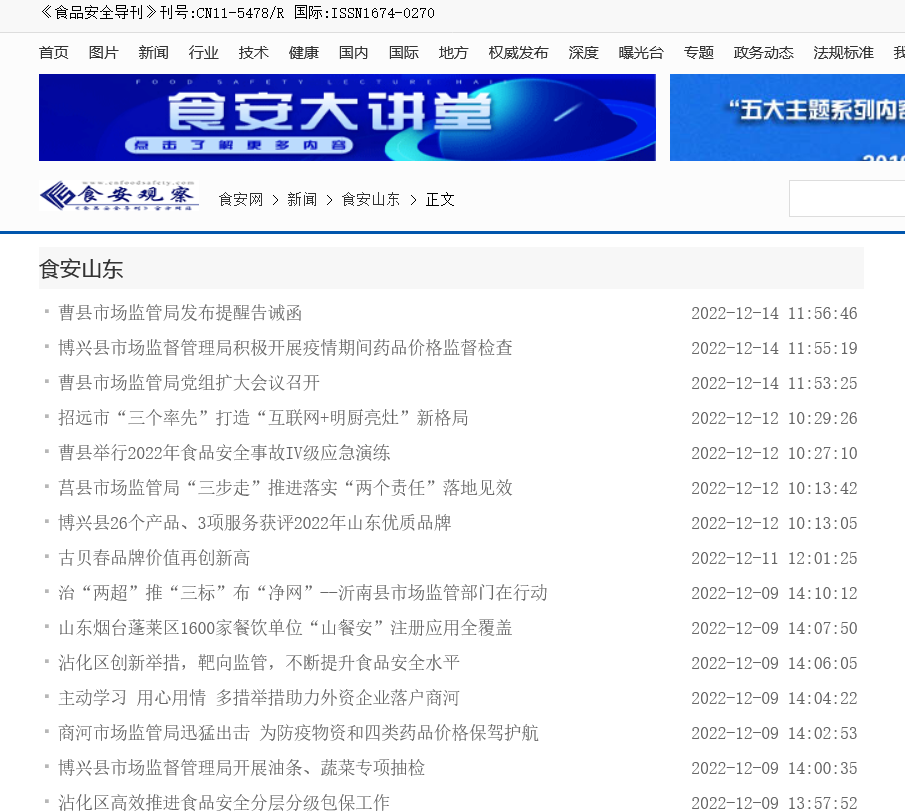

In [10]:
result = map(lambda x: str(x) + '.html', range(2,40))
pages = ['index.html'] + list(result)

df_tmp = spider_multipage('http://www.cnfoodsafety.com/news/bgt/', 
                      'http://www.cnfoodsafety.com/20', 
                      title = '食安网 - 曝光台专栏',
                      pages = pages, links = 100)

df = df.append(df_tmp,ignore_index=True)
df.count()

1 Visiting: http://www.cnfoodsafety.com/news/bgt/index.html
 **Success!**
2 Visiting: http://www.cnfoodsafety.com/2023/0214/69472.html
 **Success!**
3 Visiting: http://www.cnfoodsafety.com/2023/0214/69471.html
 **Success!**
4 Visiting: http://www.cnfoodsafety.com/2023/0214/69470.html
 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2023/0214/69469.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2023/0214/69468.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2023/0214/69467.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2023/0214/69466.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2023/0214/69465.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2023/0213/69452.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2023/0213/69451.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2023/0213/69450.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2023/0213/69449.html
 **Success!**
14 Visiting: http://ww

 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2023/0120/69184.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2023/0118/69173.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2023/0118/69172.html
 **Success!**
14 Visiting: http://www.cnfoodsafety.com/2023/0118/69171.html
 **Success!**
15 Visiting: http://www.cnfoodsafety.com/2023/0118/69170.html
 **Success!**
16 Visiting: http://www.cnfoodsafety.com/2023/0118/69169.html
 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2023/0118/69168.html
 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2023/0118/69167.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2023/0118/69166.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2023/0118/69165.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2023/0118/69164.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2023/0118/69163.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2023/0118/69162.html
 **Success!*

 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2022/1207/68721.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2022/1207/68720.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2022/1207/68719.html
 **Success!**
24 Visiting: http://www.cnfoodsafety.com/2022/1207/68718.html
 **Success!**
25 Visiting: http://www.cnfoodsafety.com/2022/1202/68664.html
 **Success!**
26 Visiting: http://www.cnfoodsafety.com/2022/1202/68663.html
 **Success!**
27 Visiting: http://www.cnfoodsafety.com/2022/1202/68662.html
 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2022/1202/68661.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2022/1202/68660.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2022/1202/68659.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2022/1202/68658.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2022/1129/68625.html
 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2022/1129/68624.html
 **Success!*

 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2022/1104/68283.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2022/1104/68282.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2022/1104/68280.html
 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2022/1104/68279.html
 **Success!**
34 Visiting: http://www.cnfoodsafety.com/2022/1101/68245.html
 **Success!**
35 Visiting: http://www.cnfoodsafety.com/2022/1031/68229.html
 **Success!**
36 Visiting: http://www.cnfoodsafety.com/2022/1031/68228.html
 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2022/1031/68227.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2022/1031/68226.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2022/1031/68225.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2022/1031/68224.html
 **Success!**
41 Visiting: http://www.cnfoodsafety.com/2022/1031/68223.html
 **Success!**
42 Visiting: http://www.cnfoodsafety.com/2022/1031/68222.html
 **Success!*

 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2022/1009/67955.html
 **Success!**
41 Visiting: http://www.cnfoodsafety.com/2022/1009/67954.html
 **Success!**
42 Visiting: http://www.cnfoodsafety.com/2022/1009/67953.html
 **Success!**
43 Visiting: http://www.cnfoodsafety.com/2022/0930/67926.html
 **Success!**
44 Visiting: http://www.cnfoodsafety.com/2022/0930/67925.html
 **Success!**
45 Visiting: http://www.cnfoodsafety.com/2022/0930/67924.html
 **Success!**
46 Visiting: http://www.cnfoodsafety.com/2022/0930/67923.html
 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2022/0928/67906.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2022/0928/67904.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2022/0928/67903.html
 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2022/0928/67902.html
 **Success!**
51 Visiting: http://www.cnfoodsafety.com/2022/0928/67901.html
 **Success!**
52 Visiting: http://www.cnfoodsafety.com/2022/0928/67900.html
 **Success!*

 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2022/0708/66638.html
 **Success!**
51 Visiting: http://www.cnfoodsafety.com/2022/0708/66637.html
 **Success!**
52 Visiting: http://www.cnfoodsafety.com/2022/0708/66636.html
 **Success!**
53 Visiting: http://www.cnfoodsafety.com/2022/0708/66635.html
 **Success!**
54 Visiting: http://www.cnfoodsafety.com/2022/0708/66634.html
 **Success!**
55 Visiting: http://www.cnfoodsafety.com/2022/0708/66633.html
 **Success!**
56 Visiting: http://www.cnfoodsafety.com/2022/0706/66589.html
 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2022/0706/66588.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2022/0706/66587.html
 **Success!**
59 Visiting: http://www.cnfoodsafety.com/2022/0706/66586.html
 **Success!**
60 Visiting: http://www.cnfoodsafety.com/2022/0706/66585.html
 **Success!**
61 Visiting: http://www.cnfoodsafety.com/2022/0706/66584.html
 **Success!**
62 Visiting: http://www.cnfoodsafety.com/2022/0704/66554.html
 **Success!*

 **Success!**
60 Visiting: http://www.cnfoodsafety.com/2022/0617/66272.html
 **Success!**
61 Visiting: http://www.cnfoodsafety.com/2022/0617/66271.html
 **Success!**
62 Visiting: http://www.cnfoodsafety.com/2022/0617/66270.html
 **Success!**
63 Visiting: http://www.cnfoodsafety.com/2022/0617/66269.html
 **Success!**
64 Visiting: http://www.cnfoodsafety.com/2022/0617/66268.html
 **Success!**
65 Visiting: http://www.cnfoodsafety.com/2022/0615/66209.html
 **Success!**
66 Visiting: http://www.cnfoodsafety.com/2021/1014/61206.html
 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!**
70 Visiting: http://www.cnfoodsafety.com/2021/0804/59311.html
 **Success!**
71 Visiting: http://www.cnfoodsafety.com/2022/0830/67434.html
 **Success!**
72 Visiting: http://www.cnfoodsafety.com/2022/0617/66281.html
 **Success!*

 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!**
70 Visiting: http://www.cnfoodsafety.com/2021/0804/59311.html
 **Success!**
71 Visiting: http://www.cnfoodsafety.com/2022/0830/67434.html
 **Success!**
72 Visiting: http://www.cnfoodsafety.com/2022/0617/66281.html
 **Success!**
73 Visiting: http://www.cnfoodsafety.com/2021/1108/61754.html
 **Success!**
74 Visiting: http://www.cnfoodsafety.com/2021/1011/61026.html
 **Success!**
75 Visiting: http://www.cnfoodsafety.com/2016/1028/20992.html
 **Success!**
76 Visiting: http://www.cnfoodsafety.com/2016/0328/17786.html
 **Success!**
77 Visiting: http://www.cnfoodsafety.com/2015/1214/16209.html
 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2015/0904/14495.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2014/1021/5320.html
 **Success!**
80 Visiting: http://www.cnfoodsafety.com/2015/1009/15073.html
 **Success!**
81 Visiting: http://www.cnfoodsafety.com/2016/0328/17785.html
 **Success!**

 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2014/1021/5320.html
 **Success!**
80 Visiting: http://www.cnfoodsafety.com/2015/1009/15073.html
 **Success!**
81 Visiting: http://www.cnfoodsafety.com/2016/0328/17785.html
 **Success!**
82 Visiting: http://www.cnfoodsafety.com/2014/0725/1494.html
 **Success!**
83 Visiting: http://www.cnfoodsafety.com/2016/0526/18699.html
 **Success!**
84 Visiting: http://www.cnfoodsafety.com/2016/1021/20882.html
 **Success!**
85 Visiting: http://www.cnfoodsafety.com/2020/1127/53806.html
 **Success!**
86 Visiting: http://www.cnfoodsafety.com/2020/0203/47938.html
 **Success!**
87 Visiting: http://www.cnfoodsafety.com/2016/1024/20934.html
 **Success!**
88 Visiting: http://www.cnfoodsafety.com/2015/1009/15075.html
 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2015/1009/15074.html
 **Success!**
90 Visiting: http://www.cnfoodsafety.com/2015/0831/14413.html
 **Success!**
91 Visiting: http://www.cnfoodsafety.com/2018/1026/33325.html
 **Success!**


 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2015/1009/15074.html
 **Success!**
90 Visiting: http://www.cnfoodsafety.com/2015/0831/14413.html
 **Success!**
91 Visiting: http://www.cnfoodsafety.com/2018/1026/33325.html
 **Success!**
92 Visiting: http://www.cnfoodsafety.com/2018/1010/32383.html
 **Success!**
93 Visiting: http://www.cnfoodsafety.com/2018/0831/30527.html
 **Success!**
94 Visiting: http://www.cnfoodsafety.com/2015/0730/13573.html
 **Success!**
95 Visiting: http://www.cnfoodsafety.com/2015/0324/9872.html
 **Success!**
96 Visiting: http://www.cnfoodsafety.com/2021/0729/59177.html
 **Success!**
97 Visiting: http://www.cnfoodsafety.com/2015/0610/12245.html
 **Success!**
98 Visiting: http://www.cnfoodsafety.com/2018/0531/27351.html
 **Success!**
99 Visiting: http://www.cnfoodsafety.com/2018/0624/27715.html
 **Success!**
100 Visiting: http://www.cnfoodsafety.com/2014/1020/5196.html
 **Success!**
1 Visiting: http://www.cnfoodsafety.com/news/bgt/11.html
 **Success!**
2 Vi

 **Success!**
99 Visiting: http://www.cnfoodsafety.com/2018/0624/27715.html
 **Success!**
100 Visiting: http://www.cnfoodsafety.com/2014/1020/5196.html
 **Success!**
1 Visiting: http://www.cnfoodsafety.com/news/bgt/12.html
 **Success!**
2 Visiting: http://www.cnfoodsafety.com/2022/0331/64810.html
 **Success!**
3 Visiting: http://www.cnfoodsafety.com/2022/0330/64804.html
 **Success!**
4 Visiting: http://www.cnfoodsafety.com/2022/0330/64803.html
 **Success!**
5 Visiting: http://www.cnfoodsafety.com/2022/0330/64802.html
 **Success!**
6 Visiting: http://www.cnfoodsafety.com/2022/0329/64779.html
 **Success!**
7 Visiting: http://www.cnfoodsafety.com/2022/0329/64778.html
 **Success!**
8 Visiting: http://www.cnfoodsafety.com/2022/0329/64777.html
 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2022/0328/64749.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2022/0328/64748.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2022/0328/64747.html
 **Success!**
12 Visiting

 **Success!**
9 Visiting: http://www.cnfoodsafety.com/2022/0309/64182.html
 **Success!**
10 Visiting: http://www.cnfoodsafety.com/2022/0308/64158.html
 **Success!**
11 Visiting: http://www.cnfoodsafety.com/2022/0308/64157.html
 **Success!**
12 Visiting: http://www.cnfoodsafety.com/2022/0308/64156.html
 **Success!**
13 Visiting: http://www.cnfoodsafety.com/2022/0308/64155.html
 **Success!**
14 Visiting: http://www.cnfoodsafety.com/2022/0308/64154.html
 **Success!**
15 Visiting: http://www.cnfoodsafety.com/2022/0307/64129.html
 **Success!**
16 Visiting: http://www.cnfoodsafety.com/2022/0307/64128.html
 **Success!**
17 Visiting: http://www.cnfoodsafety.com/2022/0307/64126.html
 **Success!**
18 Visiting: http://www.cnfoodsafety.com/2022/0307/64125.html
 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2022/0307/64124.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2022/0307/64123.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2022/0307/64122.html
 **Success!**

 **Success!**
19 Visiting: http://www.cnfoodsafety.com/2021/0426/56885.html
 **Success!**
20 Visiting: http://www.cnfoodsafety.com/2021/0424/56851.html
 **Success!**
21 Visiting: http://www.cnfoodsafety.com/2021/0418/56687.html
 **Success!**
22 Visiting: http://www.cnfoodsafety.com/2021/0410/56525.html
 **Success!**
23 Visiting: http://www.cnfoodsafety.com/2021/0409/56517.html
 **Success!**
24 Visiting: http://www.cnfoodsafety.com/2021/0408/56484.html
 **Success!**
25 Visiting: http://www.cnfoodsafety.com/2021/0408/56467.html
 **Success!**
26 Visiting: http://www.cnfoodsafety.com/2021/0402/56376.html
 **Success!**
27 Visiting: http://www.cnfoodsafety.com/2021/0401/56329.html
 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2021/0330/56290.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2021/0330/56263.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2021/0324/56168.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2021/0317/55979.html
 **Success!*

 **Success!**
28 Visiting: http://www.cnfoodsafety.com/2019/0410/39363.html
 **Success!**
29 Visiting: http://www.cnfoodsafety.com/2019/0409/39344.html
 **Success!**
30 Visiting: http://www.cnfoodsafety.com/2019/0408/39313.html
 **Success!**
31 Visiting: http://www.cnfoodsafety.com/2019/0408/39312.html
 **Success!**
32 Visiting: http://www.cnfoodsafety.com/2019/0408/39308.html
 **Success!**
33 Visiting: http://www.cnfoodsafety.com/2019/0402/39182.html
 **Success!**
34 Visiting: http://www.cnfoodsafety.com/2019/0402/39180.html
 **Success!**
35 Visiting: http://www.cnfoodsafety.com/2019/0402/39179.html
 **Success!**
36 Visiting: http://www.cnfoodsafety.com/2019/0402/39178.html
 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2019/0402/39161.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2019/0329/39092.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2019/0329/39056.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2019/0328/39007.html
 **Success!*

 **Success!**
37 Visiting: http://www.cnfoodsafety.com/2016/0629/19163.html
 **Success!**
38 Visiting: http://www.cnfoodsafety.com/2016/0629/19162.html
 **Success!**
39 Visiting: http://www.cnfoodsafety.com/2016/0629/19161.html
 **Success!**
40 Visiting: http://www.cnfoodsafety.com/2016/0608/18932.html
 **Success!**
41 Visiting: http://www.cnfoodsafety.com/2016/0531/18889.html
 **Success!**
42 Visiting: http://www.cnfoodsafety.com/2016/0526/18699.html
 **Success!**
43 Visiting: http://www.cnfoodsafety.com/2016/0525/18680.html
 **Success!**
44 Visiting: http://www.cnfoodsafety.com/2016/0519/18610.html
 **Success!**
45 Visiting: http://www.cnfoodsafety.com/2016/0424/18210.html
 **Success!**
46 Visiting: http://www.cnfoodsafety.com/2016/0408/18017.html
 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2016/0328/17788.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2016/0328/17787.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2016/0328/17786.html
 **Success!*

 **Success!**
46 Visiting: http://www.cnfoodsafety.com/2015/0902/14469.html
 **Success!**
47 Visiting: http://www.cnfoodsafety.com/2015/0831/14411.html
 **Success!**
48 Visiting: http://www.cnfoodsafety.com/2015/0812/13910.html
 **Success!**
49 Visiting: http://www.cnfoodsafety.com/2015/0811/13879.html
 **Success!**
50 Visiting: http://www.cnfoodsafety.com/2015/0804/13713.html
 **Success!**
51 Visiting: http://www.cnfoodsafety.com/2015/0803/13678.html
 **Success!**
52 Visiting: http://www.cnfoodsafety.com/2015/0730/13570.html
 **Success!**
53 Visiting: http://www.cnfoodsafety.com/2015/0729/13544.html
 **Success!**
54 Visiting: http://www.cnfoodsafety.com/2015/0729/13525.html
 **Success!**
55 Visiting: http://www.cnfoodsafety.com/2015/0729/13507.html
 **Success!**
56 Visiting: http://www.cnfoodsafety.com/2015/0720/13136.html
 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2015/0709/12958.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2015/0702/12787.html
 **Success!*

 **Success!**
56 Visiting: http://www.cnfoodsafety.com/2014/1212/7519.html
 **Success!**
57 Visiting: http://www.cnfoodsafety.com/2014/1211/7486.html
 **Success!**
58 Visiting: http://www.cnfoodsafety.com/2014/1211/7465.html
 **Success!**
59 Visiting: http://www.cnfoodsafety.com/2014/1211/7461.html
 **Success!**
60 Visiting: http://www.cnfoodsafety.com/2014/1211/7429.html
 **Success!**
61 Visiting: http://www.cnfoodsafety.com/2014/1210/7402.html
 **Success!**
62 Visiting: http://www.cnfoodsafety.com/2014/1209/7290.html
 **Success!**
63 Visiting: http://www.cnfoodsafety.com/2014/1209/7286.html
 **Success!**
64 Visiting: http://www.cnfoodsafety.com/2014/1203/7090.html
 **Success!**
65 Visiting: http://www.cnfoodsafety.com/2014/1202/7062.html
 **Success!**
66 Visiting: http://www.cnfoodsafety.com/2021/1014/61206.html
 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visit

 **Success!**
67 Visiting: http://www.cnfoodsafety.com/2021/0928/60830.html
 **Success!**
68 Visiting: http://www.cnfoodsafety.com/2021/0916/60605.html
 **Success!**
69 Visiting: http://www.cnfoodsafety.com/2021/0806/59396.html
 **Success!**
70 Visiting: http://www.cnfoodsafety.com/2021/0804/59311.html
 **Success!**
71 Visiting: http://www.cnfoodsafety.com/2022/0830/67434.html
 **Success!**
72 Visiting: http://www.cnfoodsafety.com/2022/0617/66281.html
 **Success!**
73 Visiting: http://www.cnfoodsafety.com/2021/1108/61754.html
 **Success!**
74 Visiting: http://www.cnfoodsafety.com/2021/1011/61026.html
 **Success!**
75 Visiting: http://www.cnfoodsafety.com/2016/1028/20992.html
 **Success!**
76 Visiting: http://www.cnfoodsafety.com/2016/0328/17786.html
 **Success!**
77 Visiting: http://www.cnfoodsafety.com/2015/1214/16209.html
 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2015/0904/14495.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2015/1009/15073.html
 **Success!*

 **Success!**
78 Visiting: http://www.cnfoodsafety.com/2016/0308/17514.html
 **Success!**
79 Visiting: http://www.cnfoodsafety.com/2015/0915/14682.html
 **Success!**
80 Visiting: http://www.cnfoodsafety.com/2015/0825/14313.html
 **Success!**
81 Visiting: http://www.cnfoodsafety.com/2015/0825/14294.html
 **Success!**
82 Visiting: http://www.cnfoodsafety.com/2015/0820/14149.html
 **Success!**
83 Visiting: http://www.cnfoodsafety.com/2015/0820/14148.html
 **Success!**
84 Visiting: http://www.cnfoodsafety.com/2015/0820/14147.html
 **Success!**
85 Visiting: http://www.cnfoodsafety.com/2015/0820/14146.html
 **Success!**
86 Visiting: http://www.cnfoodsafety.com/2015/1203/16048.html
 **Success!**
87 Visiting: http://www.cnfoodsafety.com/2015/1127/15930.html
 **Success!**
88 Visiting: http://www.cnfoodsafety.com/2015/1112/15675.html
 **Success!**
89 Visiting: http://www.cnfoodsafety.com/2015/0812/13910.html
 **Success!**
90 Visiting: http://www.cnfoodsafety.com/2015/1009/15072.html
 **Success!*

C:\Users\eleve\anaconda3\lib\site-packages\tables\leaf.py:402: PerformanceWarning: The Leaf ``/df/_i_table/content/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


saved to  20230215123447


C:\Users\eleve\AppData\Local\Temp\ipykernel_8204\1094426759.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp,ignore_index=True)


label      5768
src        5768
url        5768
date       5768
title      5768
content    5768
dtype: int64

## 可选：导入其他类型文本数据

为后续文本分类用

## 合并2018爬虫结果

In [11]:
import pandas as pd

with pd.HDFStore('FoodSafetyAriticles2018.h5',  mode='r') as newstore:
    df_restored = newstore.select('df')
    
df = df.append(df_restored,ignore_index=True)
df.drop_duplicates(subset="url", inplace=True)
df.drop_duplicates(subset="content", inplace=True)

C:\Users\eleve\AppData\Local\Temp\ipykernel_8204\1048050151.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_restored,ignore_index=True)


In [19]:
df=df[df['label'] == '食品安全']

# 保存合并的df到h5文件

In [17]:
with pd.HDFStore('FoodSafetyAriticles2023.h5',  mode='w') as store:
    store.append('df', df, data_columns= df.columns, format='table')

C:\Users\eleve\anaconda3\lib\site-packages\tables\leaf.py:402: PerformanceWarning: The Leaf ``/df/_i_table/content/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


语料时间跨度：2013 - 2023

In [20]:
df

,label,src,url,date,title,content
0,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9934,市场监管总局发布12批次食品抽检不合格情况通告,\n\r\n 摘要：近日，国家市场监督管理总局公布12批次食品...
1,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9910,市场监管总局关于11批次食品不合格情况的通告【2022】,\n\r\n 摘要：近日，国家市场监督管理总局公布11批次食品...
2,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9854,市场监管总局关于11批次食品不合格情况的通告【2022】,\n\r\n 摘要：近日，国家市场监督管理总局公布11批次食品...
3,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9581,市场监管总局通告13批次食品不合格,\n\r\n 摘要：近日，国家市场监督管理总局公布13批次食品...
4,食品安全,中国食品安全网 - 抽检通告,https://www.cfsn.cn/front/web/site.bwnewshow?b...,d=9539,市场监管总局关于10批次食品不合格情况的通告【2022】,\n\r\n 摘要：近日，国家市场监督管理总局公布10批次食品...
...,...,...,...,...,...,...
10411,食品安全,中国食品安全网 - 曝光专栏,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n 专家观点\r\n,\n\n中国食品科学技术学会常务理事 李宁\n乳矿物盐是经过安全性评价卫生部批准公告的新资源...
10412,食品安全,中国食品安全网 - 曝光专栏,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n “肯德基汉堡细菌超标”热点概况\r\n,\n\n\n2012年10月19日，长沙市第三季度食品安全检验检测情况出炉，长沙肯德基有限公...
10413,食品安全,中国食品安全网 - 曝光专栏,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n 专家观点\r\n,\n\n中国食品科学技术学会副理事长 刘秀梅\n汉堡是餐饮单位以面包加肉肠、蔬菜和奶酪等多种...
10414,食品安全,中国食品安全网 - 曝光专栏,http://www.cfsn.cn/zhuanti/2013-01/06/content_...,2013-01/06,\r\n “白酒塑化剂超标门”热点概况\r\n,\n\n2012年11月19日，21世纪网以“致命危机：酒鬼酒塑化剂超标260%”为题报道5...


以上代码仅需要运行一次

# 加载

In [ ]:
import pandas as pd

with pd.HDFStore('FoodSafetyAriticles2023.h5',  mode='r') as newstore:
    df = newstore.select('df')

### PYNIPIR(ICTCLAS - Institute of Computing Technology，Chinese Lexical Analysis System)

> pip install pynlpir   
> pynlpir update

In [21]:
import pynlpir  # 引入依赖包
pynlpir.open()  # 打开分词器

from ctypes import c_char_p
pynlpir.nlpir.AddUserWord(c_char_p("食品安全".encode()))

for item in df.values[:5]:
    print(item[2], '\t', pynlpir.segment(item[2], pos_english=False, pos_tagging=True), '\n', pynlpir.get_key_words(item[3]), '\n\n')
    
pynlpir.close()

dir(pynlpir)

ModuleNotFoundError: No module named 'pynlpir'

### SnowNLP

In [22]:
from snownlp import SnowNLP

for item in df.values[:10]:
    s = SnowNLP(item[3])
    print(item[2], '\t', s.keywords(5), '\n', s.summary(3), '\n\n')

ModuleNotFoundError: No module named 'snownlp'

In [7]:
from snownlp import SnowNLP

s = SnowNLP(u'这个东西真心很赞')

print(s.words)         # [u'这个', u'东西', u'真心',
                #  u'很', u'赞']

print(s.sentiments)    # 0.9769663402895832 positive的概率

print(s.pinyin)        # [u'zhe', u'ge', u'dong', u'xi',
                #  u'zhen', u'xin', u'hen', u'zan']

['这个', '东西', '真心', '很', '赞']
0.9769551298267365
['zhe', 'ge', 'dong', 'xi', 'zhen', 'xin', 'hen', 'zan']


In [15]:
for tag in s.tags:
    print(tag)

('这个', 'r')
('东西', 'n')
('真心', 'd')
('很', 'd')
('赞', 'Vg')


In [4]:
s = SnowNLP(u'「繁體字」「繁體中文」的叫法在臺灣亦很常見。')

s.han           # u'「繁体字」「繁体中文」的叫法
                # 在台湾亦很常见。'

'「繁体字」「繁体中文」的叫法在台湾亦很常见。'

In [19]:
text = u'''
自然语言处理是计算机科学领域与人工智能领域中的一个重要方向。
它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法。
自然语言处理是一门融语言学、计算机科学、数学于一体的科学。
因此，这一领域的研究将涉及自然语言，即人们日常使用的语言，
所以它与语言学的研究有着密切的联系，但又有重要的区别。
自然语言处理并不是一般地研究自然语言，
而在于研制能有效地实现自然语言通信的计算机系统，
特别是其中的软件系统。因而它是计算机科学的一部分。
'''

s = SnowNLP(text)

print(s.keywords(3))

print(s.summary(2))

print(s.sentences)

['语言', '自然', '计算机']
['因而它是计算机科学的一部分', '自然语言处理是计算机科学领域与人工智能领域中的一个重要方向']
['自然语言处理是计算机科学领域与人工智能领域中的一个重要方向', '它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法', '自然语言处理是一门融语言学、计算机科学、数学于一体的科学', '因此', '这一领域的研究将涉及自然语言', '即人们日常使用的语言', '所以它与语言学的研究有着密切的联系', '但又有重要的区别', '自然语言处理并不是一般地研究自然语言', '而在于研制能有效地实现自然语言通信的计算机系统', '特别是其中的软件系统', '因而它是计算机科学的一部分']
